#<b>Machine translation based on LSTM

## **Context**
Machine translation (MT) is the process of translating text in one language to another language with the use of software by incorporating both computational and linguistic knowledge.<br></br>  NMT is a recently formulated method for automatic translation with the help of deep neural networks.  NMT uses a single large neural network for training. This structure comprised of encoder and decoder networks where the encoder consumes the input sentences to produce a vector representation, and the decoder takes this vector and outputs the target language words.Generally, both encoder and decoder networks are designed using the recurrent neural networks (RNN) or long short-term memory (LSTM) or gated recurrent unit (GRU) or bidirectional RNN, which are the alternatives to RNN. Even though RNN, especially LSTM, is theoretically proven for handling long-term dependencies in the sentences<br></br>
Here, in this case study we use a simple RNN model combined with lstm nodes for our translation task.

## **Downloading the Required Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## **Downloading the Required Dataset**

In [ ]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 'replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y',
 '  inflating: _about.txt              ',
 'replace fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n']

## **Setting Up Hyperparameters**

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"

In [ ]:
# Vectorizing the data and storing them in lists
input_texts = []
target_texts = []


# Sets for Creating vocabulary of Input Characters
input_characters = set()
target_characters = set()


# Reading File with utf-8 encoding
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

# Separating input and target texts and storing themin different lists.
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)

    # Adding Unique Characters to the Input Characters array to create vocabulary
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


## **Tokenizing and Vectorizing the Text**

Here we are building a Character level translation tool. So each token of our Input text shall be a charaxter and each token of the target text will be a French character. We therefore convert the input data into a three dimensional array. The first dimension consists of number of English to French pairs, the second dimension consists of the length of each sentence. ( Here, we are taking the length of each sentence to be the length of the longest sentence in each of these languages, and for sentences whose lengths are smaller than the highest length, we are padding them with the ' ' token or a blank space token). The third dimension has a length equal to number of unique characters in that particular language, as this vector is a one-hot encoded vector for English and French alphabets.

In [ ]:
# Creating array of zeros with mentioned shape 
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)



# Populating the arrays 
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0 # From (t + 1)th time step, all characters are padded with a blank space character
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

## **Encoder and Decoder Architecture**

The Architecture has two units, the Encoder LSTM blocks and the Decoder LSTM blocks. 

Theoretically in a Sequence to Sequence architecture, the output of the Decoder at one time step is used as an input for the next decoder time step. But during training, we are using the Ground Truth value for the input to the next decoder time step, so that our model learns better. This is called Teacher forcing.

We shall however change this in the inference or the testing stage, where we shall use the more traditional method of using the output of previous decoder time step as the current input to predict the output character.

## **Building the Model**

In [ ]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


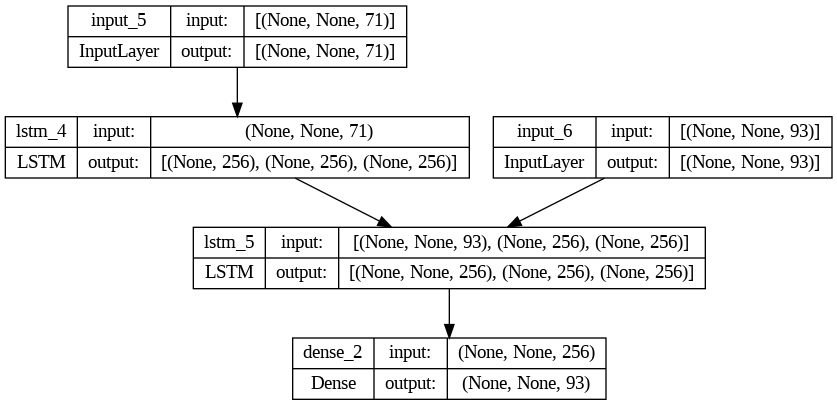

In [ ]:
 # plotting the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

## **Training the Model**

In [ ]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ["accuracy"])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 4s 18ms/step - loss: 0.3823 - accuracy: 0.8853 - val_loss: 0.4770 - val_accuracy: 0.8583
Epoch 2/100
125/125 [==============================] - 1s 12ms/step - loss: 0.3649 - accuracy: 0.8902 - val_loss: 0.4651 - val_accuracy: 0.8636
Epoch 3/100
125/125 [==============================] - 1s 12ms/step - loss: 0.3503 - accuracy: 0.8945 - val_loss: 0.4596 - val_accuracy: 0.8653
Epoch 4/100
125/125 [==============================] - 1s 12ms/step - loss: 0.3365 - accuracy: 0.8985 - val_loss: 0.4554 - val_accuracy: 0.8668
Epoch 5/100
125/125 [==============================] - 1s 11ms/step - loss: 0.3237 - accuracy: 0.9022 - val_loss: 0.4461 - val_accuracy: 0.8700
Epoch 6/100
125/125 [==============================] - 1s 12ms/step - loss: 0.3116 - accuracy: 0.9059 - val_loss: 0.4429 - val_accuracy: 0.8711
Epoch 7/100
125/125 [==============================] - 2s 12ms/step - loss: 0.3002 - accuracy: 0.9093 - val_loss: 0.4398 - val_accuracy:

## **Inference Stage**

We have to manually perform inference because, our model had teacher forcing during Training. However, in the Inference Stage, we have to use the output of the previous timestep as the input for next timestep.

In [ ]:
# Manually deriving the decoder states and decoder outputs so that we can reuse decoder outputs as inputs for next step
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
# Mapping between integers or indexes and characters.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
# decoding the output sentence from output tokenized data
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the firhttps://colab.research.google.com/drive/1POsKAPn78VkMMTseSTQm1w7a8RsrTa-W#scrollTo=_Az5ZhvbgHQyst character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



## **Testing our Model**

In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 16ms/step
-
Input sentence: Go.
Decoded sentence: Va !

1/1 [==============================] - 0s 14ms/step
-
Input sentence: Go.
Decoded sentence: Va !

1/1 [==============================] - 0s 15ms/step
-
Input sentence: Go.
Decoded sentence: Va !

1/1 [==============================] - 0s 16ms/step
-
Input sentence: Go.
Decoded sentence: Va !

1/1 [==============================] - 0s 15ms/step
-
Input sentence: Hi.
Decoded sentence: Salemenons !

1/1 [==============================] - 0s 15ms/step
-
Input sentence: Hi.
Decoded sentence: Salemenons !

1/1 [==============================] - 0s 17ms/step
-
Input sentence: Run!
Decoded sentence: Fuyez !

1/1 [==============================] - 0s 14ms/step
-
Input sentence: Run!
Decoded sentence: Fuyez !

1/1 [==============================] - 0s 16ms/step
-
Input sentence: Run!
Decoded sentence: Fuyez !

1/1 [==============================] - 0s 15ms/step
-
Input sentence: Run!
Decoded sentenc

## **Conclusion**

- The model is trained on Character basis, therefore the model focuses more on the translatory accuracy of each words,
- We can try testing our model over a different range of data. For that we shall need to change the sequence indexes in the iterator for generating these results.